# Method: RC 
# Dataset: Lorenz-96, F = 8
# Purpose: Uncertainty Quantification - Mean Variance Estimation

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [4]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [5]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [6]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [7]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RC Implementation

In [8]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def neg_log_LH(params, x, y):
        """
        returns negative-log-likelihood -logLH(P(y|params))
        """
        d = data_dim
        beta, intercept, beta2, intercept2 = params
        
        mu = x @ beta + intercept  # train_size x data_dim
        
        log_sigma = (x @ beta2 + intercept2).mean() # train_size x 1
        sigma = jnp.exp(log_sigma)
        
        mu_loss = mse(mu, y)
        constant = d * jnp.log(2 * jnp.pi)
        sigma_loss = d * log_sigma
        return 0.5*(constant + sigma_loss + (mu_loss / sigma**2))

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept, beta2, intercept2) where 
        beta, intercept -> weights to determine the mean
        beta2, intecept2 -> weights to determine log_sigma
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        beta2 size = nn_size x 1
        intercept2 = 1 (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(neg_log_LH)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        beta2 = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, 1))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        intercept2 = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (1, ))
        
        t_size = int(1. * train_size)
        
        overall_best_loss = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept, beta2, intercept2])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train) # -ve log likelihood
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch > 249):
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training Loss : {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_loss:
                print("IMPROVED VALIDATION LOSS")
                overall_best_loss = best_val_loss
                overall_best_state = best_state
            
            beta, intercept, beta2, intercept2 = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept, beta2, intercept2
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [9]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept, beta2, intercept2 = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        log_sd = beta2.T @ np.concatenate([z, z**2]) + intercept2 # log_sd of output | size = 1 
        mus.append(x)
        stddevs.append(jnp.exp(log_sd[0]))
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            log_sd = beta2.T @ np.concatenate([z, z**2]) + intercept2
            mus.append(x)
            stddevs.append(jnp.exp(log_sd[0]))
        
        return mus, stddevs
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        mean, sd = prediction(data_test[i])
        mean_list.append(mean)
        sd_list.append(sd)
        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list), np.array(sd_list)

In [10]:
def neg_log_LH(mean_pred, sd_pred):
    d = data_dim
    
    constant_loss = d * np.log(2 * np.pi)
    mu_loss = (mean_pred - y_test)**2
    if len(sd_pred.shape) == 2:
        sd_expanded = np.moveaxis(np.tile(sd_pred, (d, 1, 1)), 0, 2)# Repeat sd for each of the 40 dimensions 
    elif len(sd_pred.shape) == 3:
        sd_expanded = sd_pred
    else:
        raise Exception("Invalid sd_pred dimension")
    
    return 0.5 * (constant_loss + d * np.log(sd_expanded) + (mu_loss / sd_expanded**2)).mean(axis = (0, 2))

In [11]:
def get_test_pred_sampled(data_test, params, W_in, W, seed):
    np.random.seed(seed)
    start = time()
    
    beta, intercept, beta2, intercept2 = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def generate_hidden_state(data):
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ data[i] + W @ z)
        return z
    
    test_mus = []
    test_sds = []
    counter = 0
    
    for inp in data_test:
        z = generate_hidden_state(inp)
        first_mean = beta.T @ np.concatenate([z, z**2]) + intercept
        first_log_sd = beta2.T @ np.concatenate([z, z**2]) + intercept2
        first_sd = np.exp(first_log_sd[0])

        x = first_mean
        all_mu = []
        all_sd = []
        
        for tr in range(N_TRAJ_MVE // 5): 
            x = np.random.normal(first_mean, first_sd)
            mu_list = [x]
            sd_list = [first_sd] 

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                log_sd = beta2.T @ np.concatenate([z, z**2]) + intercept2
                mu_list.append(x)
                sd_list.append(np.exp(log_sd[0]))

            all_mu.append(np.array(mu_list))
            all_sd.append(np.array(sd_list))
        
        test_mus.append(np.array(all_mu))
        test_sds.append(np.array(all_sd))
        
        counter += 1
        
        if counter % 5 == 0:
            print(f"{counter / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.array(test_mus), np.array(test_sds) 

# 3. Best Parameters

In [12]:
nn_size = 12000
ridge_penalty = 1e-6
spec_radius = 0.1
connectivity = 4

lr_list = [1e-4]
epoch_list = [300]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

# 4. MVE Ensemble

In [13]:
res_folder = os.path.join("results", "combined")

In [14]:
def run_seed(seed):
    """
    Runs the experiment with optimal parameters and saves the predictions into a file
    """
    params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = seed, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)
    _, W_in, W = internal
    mean_pred_all, sd_pred_all = get_test_pred_sampled(X_test, params, W_in, W, seed)
    mean_pred = mean_pred_all.mean(axis = 1)
    sd_pred = np.sqrt((np.moveaxis(np.tile(sd_pred_all, (40, 1, 1, 1)), 0, 3)**2 + mean_pred_all**2).mean(axis = 1) - mean_pred**2)
    file_name = "mu_preds_" + str(seed) + ".pkl"
    file_name_2 = "sd_preds_" + str(seed) + ".pkl"
    save_obj(mean_pred, res_folder, file_name)
    save_obj(sd_pred, res_folder, file_name_2)

## 4.1 Seed 2

In [15]:
run_seed(2)

W generated. Time taken: 24.19s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.29s
W and W_in generated. Time taken: 29.86s

Generating z values...
z values generated. Time taken: 51.01s
Concatenating z with z**2 Contenation complete. Time taken: 17.30s

Epoch 10: Train time = 11.02 | Train Loss = -95.4375534 
Epoch 20: Train time = 11.24 | Train Loss = -96.4590759 
Epoch 30: Train time = 10.52 | Train Loss = -97.3538589 
Epoch 40: Train time = 10.73 | Train Loss = -98.0978928 
Epoch 50: Train time = 10.81 | Train Loss = -98.8644791 
Epoch 60: Train time = 10.70 | Train Loss = -99.4948807 
Epoch 70: Train time = 10.43 | Train Loss = -100.1297226 
Epoch 80: Train time = 10.69 | Train Loss = -100.7819138 
Epoch 90: Train time = 10.73 | Train Loss = -101.3336487 
Epoch 100: Train time = 10.80 | Train Loss = -101.8434753 
Epoch 110: Train time = 11.01 | Train Loss = -102.4694977 
Epoch 120: Train time = 10.59 | Train Loss = -102.8602829 
Epoch 130: Train time = 10.13 | Train L

## 4.2 Seed 4

In [16]:
run_seed(4)

W generated. Time taken: 20.01s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 9.83s
W and W_in generated. Time taken: 32.76s

Generating z values...
z values generated. Time taken: 46.32s
Concatenating z with z**2 Contenation complete. Time taken: 11.33s

Epoch 10: Train time = 9.81 | Train Loss = -95.4511414 
Epoch 20: Train time = 10.99 | Train Loss = -96.5233383 
Epoch 30: Train time = 10.00 | Train Loss = -97.3751373 
Epoch 40: Train time = 10.97 | Train Loss = -98.0967331 
Epoch 50: Train time = 11.09 | Train Loss = -98.8577194 
Epoch 60: Train time = 10.69 | Train Loss = -99.4472122 
Epoch 70: Train time = 8.24 | Train Loss = -100.1255035 
Epoch 80: Train time = 8.26 | Train Loss = -100.7190857 
Epoch 90: Train time = 9.53 | Train Loss = -101.4009781 
Epoch 100: Train time = 8.10 | Train Loss = -101.8534393 
Epoch 110: Train time = 8.16 | Train Loss = -102.4340744 
Epoch 120: Train time = 8.53 | Train Loss = -102.8572311 
Epoch 130: Train time = 8.05 | Train Loss = -1

## 4.3 Seed 6

In [17]:
run_seed(6)

W generated. Time taken: 19.33s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.89s
W and W_in generated. Time taken: 23.25s

Generating z values...
z values generated. Time taken: 44.27s
Concatenating z with z**2 Contenation complete. Time taken: 11.43s

Epoch 10: Train time = 8.04 | Train Loss = -95.5489120 
Epoch 20: Train time = 7.99 | Train Loss = -96.5916290 
Epoch 30: Train time = 8.03 | Train Loss = -97.4402313 
Epoch 40: Train time = 8.08 | Train Loss = -98.1618347 
Epoch 50: Train time = 8.02 | Train Loss = -98.8874054 
Epoch 60: Train time = 8.02 | Train Loss = -99.4667664 
Epoch 70: Train time = 8.01 | Train Loss = -100.1967239 
Epoch 80: Train time = 8.03 | Train Loss = -100.8007889 
Epoch 90: Train time = 8.05 | Train Loss = -101.3918076 
Epoch 100: Train time = 8.02 | Train Loss = -101.9915924 
Epoch 110: Train time = 7.83 | Train Loss = -102.5187607 
Epoch 120: Train time = 7.77 | Train Loss = -102.8912888 
Epoch 130: Train time = 7.92 | Train Loss = -103.45

## 4.4 Seed 8

In [18]:
run_seed(8)

W generated. Time taken: 19.58s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.95s
W and W_in generated. Time taken: 27.61s

Generating z values...
z values generated. Time taken: 56.09s
Concatenating z with z**2 Contenation complete. Time taken: 13.34s

Epoch 10: Train time = 9.07 | Train Loss = -95.5681915 
Epoch 20: Train time = 9.55 | Train Loss = -96.5523529 
Epoch 30: Train time = 9.04 | Train Loss = -97.3871613 
Epoch 40: Train time = 9.49 | Train Loss = -98.1600342 
Epoch 50: Train time = 9.29 | Train Loss = -98.9133301 
Epoch 60: Train time = 9.44 | Train Loss = -99.5263977 
Epoch 70: Train time = 8.98 | Train Loss = -100.2192459 
Epoch 80: Train time = 8.95 | Train Loss = -100.8397141 
Epoch 90: Train time = 9.42 | Train Loss = -101.4647293 
Epoch 100: Train time = 9.49 | Train Loss = -101.9595795 
Epoch 110: Train time = 8.36 | Train Loss = -102.4812241 
Epoch 120: Train time = 8.65 | Train Loss = -102.9240341 
Epoch 130: Train time = 8.61 | Train Loss = -103.26

## 4.5 Seed 42

In [19]:
run_seed(42)

W generated. Time taken: 20.48s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.01s
W and W_in generated. Time taken: 26.51s

Generating z values...
z values generated. Time taken: 43.19s
Concatenating z with z**2 Contenation complete. Time taken: 10.55s

Epoch 10: Train time = 7.95 | Train Loss = -95.4313049 
Epoch 20: Train time = 8.07 | Train Loss = -96.5874329 
Epoch 30: Train time = 7.93 | Train Loss = -97.4300461 
Epoch 40: Train time = 8.03 | Train Loss = -98.1296463 
Epoch 50: Train time = 7.88 | Train Loss = -98.8453064 
Epoch 60: Train time = 8.01 | Train Loss = -99.5778122 
Epoch 70: Train time = 8.02 | Train Loss = -100.1390762 
Epoch 80: Train time = 7.84 | Train Loss = -100.8174057 
Epoch 90: Train time = 7.85 | Train Loss = -101.3118362 
Epoch 100: Train time = 7.95 | Train Loss = -101.8711700 
Epoch 110: Train time = 8.01 | Train Loss = -102.4438629 
Epoch 120: Train time = 7.95 | Train Loss = -102.9410782 
Epoch 130: Train time = 7.87 | Train Loss = -103.33

## 4.6 Compilation

In [20]:
mu_preds = []
sd_preds = []

In [21]:
for dirpath, dirnames, filenames in os.walk(res_folder):
    for f in filenames:
        if f[:2] == "mu":
            mu_preds.append(load_obj(os.path.join(res_folder, f)))
        elif f[:2] == "sd":
            sd_preds.append(load_obj(os.path.join(res_folder, f)))

In [22]:
mu_preds = np.array(mu_preds)
sd_preds = np.array(sd_preds)

In [23]:
print(f"mean preds shape: {mu_preds.shape}")
print(f"sd preds shape: {sd_preds.shape}")

mean preds shape: (5, 100, 400, 40)
sd preds shape: (5, 100, 400, 40)


# 5. Analyze results

## 5.1 MSE

In [30]:
mve_s_mean = mu_preds.mean(axis = 0)
mve_s_sigma = np.sqrt((sd_preds**2 + mu_preds**2).mean(axis = 0) - mve_s_mean**2)

In [31]:
desc_name = "rc_nn" + str(nn_size) + "_combined"
res_mve = PointExperimentResult(mve_s_mean - y_test,
                                           desc_name)

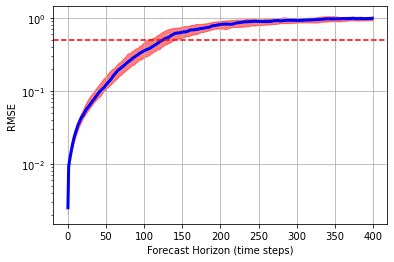

It takes around t = 1.25 for mean error to exceed 0.5


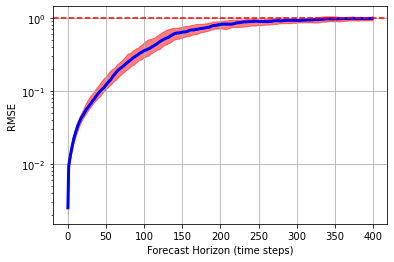

It takes around t = 0.00 for mean error to exceed 1.0


In [32]:
res_mve.plot_rmse(error_thresh = 0.5)
res_mve.plot_rmse(error_thresh = 1.)

In [38]:
res_mve.get_loss([0.2, 0.5, 1, 2, 3])

Median NRMSE at t = 0.2: 0.047
Median NRMSE at t = 0.5: 0.121
Median NRMSE at t = 1: 0.355
Median NRMSE at t = 2: 0.812
Median NRMSE at t = 3: 0.921


## 5.2 Variance

**Visualise for one dataset**

In [33]:
idx = 0

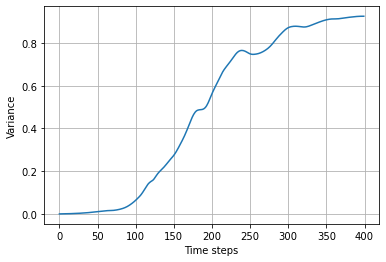

In [34]:
plt.plot(mve_s_sigma[0].mean(axis = 1)**2)
plt.grid("on")
plt.xlabel("Time steps")
plt.ylabel("Variance")
plt.show()

## 5.3 Negative Log LH

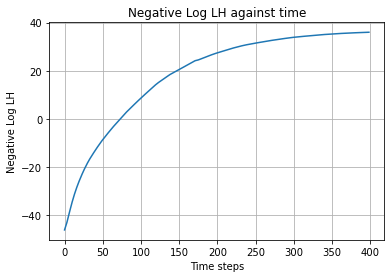

In [35]:
plt.plot(neg_log_LH(mve_s_mean, mve_s_sigma)[1:])
plt.title("Negative Log LH against time")
plt.xlabel("Time steps")
plt.ylabel("Negative Log LH")
# plt.yscale("log")
plt.grid("on")
plt.show()

In [40]:
print(f"Mean negative log LH: {neg_log_LH(mve_s_mean, mve_s_sigma).mean():.5f}")

Mean negative log LH: 18.26314
